In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf

In [5]:
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
import zipfile
path_to_zip_file = '/content/drive/MyDrive/Sehatin_File/sehatin-dataset-V1-splitted.zip'
directory_to_extract_to = '/content/sehatin-dataset'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall(directory_to_extract_to)

In [7]:
#DEFINE IMAGE DATA GENERATOR FUNCTION FOR TRAIN, VALIDATION, TEST
def datagen(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR, TARGET_SIZE, BATCH_SIZE):
  #TRAINING GENERATOR
  train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
  )
  train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',    
    shuffle=True,
    seed=42,
    class_mode='categorical')
  
  #VALIDATION GENERATOR
  valid_datagen = ImageDataGenerator(rescale=1./255)

  valid_generator = valid_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=False,    
    class_mode='categorical')
  
  #TESTING GENERATOR
  test_datagen = ImageDataGenerator(rescale=1./255)

  test_generator = test_datagen.flow_from_directory(
    TESTING_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=False,    
    class_mode='categorical')
  
  return train_generator, valid_generator, test_generator
  


In [8]:
target_size = (224, 224)
batch_size = 32

train_dir = "/content/sehatin-dataset/sehatinV1splitted/training"
val_dir   = "/content/sehatin-dataset/sehatinV1splitted/validation"
test_dir  = "/content/sehatin-dataset/sehatinV1splitted/testing"

training_generator, validation_generator, testing_generator = datagen(train_dir, val_dir, test_dir, target_size, batch_size)

Found 13906 images belonging to 76 classes.
Found 1713 images belonging to 76 classes.
Found 1801 images belonging to 76 classes.


In [10]:
labels = list(training_generator.class_indices.keys())
num_classes = len(labels)
print(labels)
print("num_classes = {}".format(num_classes))

['apple', 'apple-pie', 'asparagus', 'avocado', 'bakso', 'barley', 'bayam', 'beef', 'beverage drinks', 'blackberry', 'bluefin-tuna', 'bread', 'broccoli', 'burger', 'cake', 'cherry', 'chicken-curry', 'chicken-wings', 'corn', 'cucumber', 'donut', 'dragon-fruit', 'dumpling', 'egg-yolk', 'eggplant', 'french-fries', 'fried-chicken', 'fried-mushroom', 'fried-rice', 'grape', 'gulai', 'hotdog', 'ice-cream', 'jus alpukat', 'jus mangga', 'kacang camilan', 'lasagna', 'lettuce', 'lumpia', 'macaroni', 'mackerel-fillet', 'mango', 'melon-cantaloupe', 'mie-goreng', 'milk', 'noodle', 'oatmeal', 'omelette', 'onion-ring', 'oranges', 'oysters', 'pancakes', 'pear', 'pisang goreng', 'pizza', 'plain-yogurt', 'plate', 'pork-chop', 'potato', 'pudding', 'ramen', 'rice', 'salad', 'sambal', 'sate', 'sayur hijau', 'shrimp-cooked', 'soto', 'spaghetti', 'spring-roll', 'steak', 'tahu', 'tempe', 'tomato', 'waffles', 'yogurt']
num_classes = 76


In [11]:
keras_layer = hub.KerasLayer(
  "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  trainable=False
)

In [13]:
def build_sehatin_model(pretrained, labels):
  model = tf.keras.Sequential([
    pretrained,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(labels), activation="sigmoid"),
  ])
    
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

In [14]:
sehatin_model = build_sehatin_model(keras_layer, labels)
sehatin_model.build([None, 224, 224, 3])
sehatin_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 76)                97356     
                                                                 
Total params: 6,016,668
Trainable params: 97,356
Non-trainable params: 5,919,312
_________________________________________________________________


In [15]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') - logs.get('val_accuracy') > 0.1:
            print("\nStop the training due to its lead of overfitting!")
            self.model.stop_training = True

callbacks = myCallback()

In [16]:
history = sehatin_model.fit(
    training_generator,
    epochs=15,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/15
  7/435 [..............................] - ETA: 5:11 - loss: 4.3329 - accuracy: 0.0402

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


435/435 [==============================] - 436s 957ms/step - loss: 2.3821 - accuracy: 0.4402 - val_loss: 1.3796 - val_accuracy: 0.6585
Epoch 2/15
435/435 [==============================] - 391s 898ms/step - loss: 1.4842 - accuracy: 0.6132 - val_loss: 1.1227 - val_accuracy: 0.7104
Epoch 3/15
435/435 [==============================] - 429s 985ms/step - loss: 1.2630 - accuracy: 0.6602 - val_loss: 1.0176 - val_accuracy: 0.7256
Epoch 4/15
435/435 [==============================] - 385s 886ms/step - loss: 1.1525 - accuracy: 0.6822 - val_loss: 0.9674 - val_accuracy: 0.7315
Epoch 5/15
435/435 [==============================] - 385s 886ms/step - loss: 1.0819 - accuracy: 0.7021 - val_loss: 0.9398 - val_accuracy: 0.7350
Epoch 6/15
435/435 [==============================] - 387s 889ms/step - loss: 1.0061 - accuracy: 0.7168 - val_loss: 0.9057 - val_accuracy: 0.7507
Epoch 7/15
435/435 [==============================] - 385s 885ms/step - loss: 0.9606 - accuracy: 0.7272 - val_loss: 0.9010 - val_accura

In [17]:
testing_set = sehatin_model.evaluate(testing_generator)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


57/57 [==============================] - 31s 539ms/step - loss: 0.8053 - accuracy: 0.7651


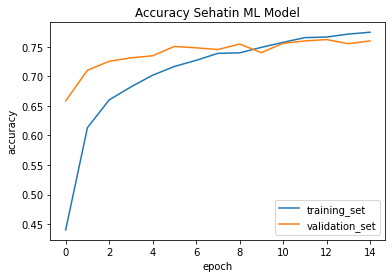

In [18]:
#Graph for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Sehatin ML Model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training_set', 'validation_set'], loc='lower right')
plt.show()

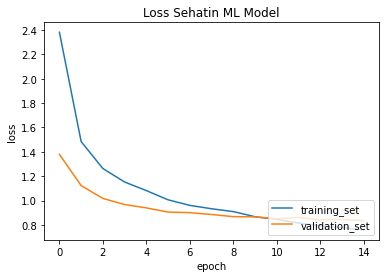

In [19]:
#Graph for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Sehatin ML Model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training_set', 'validation_set'], loc='lower right')
plt.show()

In [20]:
# SAVE AND PREPARING THE MODEL INTO TFLITE

export_dir = 'content/saved_model/1'
tf.saved_model.save(sehatin_model, export_dir)

INFO:tensorflow:Assets written to: content/saved_model/1/assets


INFO:tensorflow:Assets written to: content/saved_model/1/assets


In [22]:
import shutil
shutil.make_archive('sehatin_saved_model.zip', 'zip', '/content/content/saved_model')

'/content/sehatin_saved_model.zip.zip'

In [23]:
# UTILIZE THE CONVERTER TO OBTAIN TFLITE MODEL
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [24]:
from pathlib import Path
tflite_model_file = Path('./sehatin_modelV1.tflite')
tflite_model_file.write_bytes(tflite_model)

7028448